In [1]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

import matplotlib.pyplot as plt
import skimage.io as io
from skimage.transform import resize
import os

/home/simon/.conda/envs/tf1.12/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:523: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/simon/.conda/envs/tf1.12/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:524: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/simon/.conda/envs/tf1.12/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:525: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/simon/.conda/envs/tf1.12/lib/python3.6/site-packages

# Data

In [2]:
POS_DIR = "/home/simon/Desktop/HealthHack/data/good_side/numpy/"
NEG_DIR = "/home/simon/Desktop/HealthHack/data/bad_side/numpy/"
BATCH_SIZE = 100
IMG_DIM = 28

In [3]:
from skimage import filters

from skimage.morphology import disk
from skimage.filters.rank import median


class DataGen(object):

    def __init__(self, img_dir, img_dim, batch_size, shuffle=True, rgb=True, labels=False):
        self.img_dir = img_dir
        self.img_dim = img_dim
        self.batch_size = batch_size
        self.files = np.array([os.path.join(self.img_dir, file) for file in os.listdir(self.img_dir)])
        self.n = len(self.files)
        self.indices = np.arange(0, self.n)
        self.rgb = rgb
        self.labels = labels
        if shuffle:
            np.random.shuffle(self.indices)
        self.pos = 0

    def _get_indices(self, i):
        return self.indices[i * self.batch_size:i * self.batch_size + self.batch_size]

    def __getitem__(self, i):
        batch = []
        labels = []
        files = self.files[self._get_indices(i)]
        for file in files:
            try:
                if self.rgb:
                    img = io.imread(file) #/ 255.
                
                else:
                    img = np.load(file)
                
                
                if len(img.shape) == 3:
                    img = img[0]
                
                
                img = filters.gaussian(img, sigma=3)
                
                if img.shape[0] != self.img_dim or img.shape[1] != self.img_dim:
                    img = resize(img, (self.img_dim, self.img_dim))
                    

                #img = median((img*255.).astype("uint8"), disk(2)) / 255.
                
                #img = filters.roberts(img)
                
                # Augment left to right
                if np.random.random() > 0.5:
                    img = np.fliplr(img)
                
                # Augment rot90
                turns = np.random.choice([0, 1, 2, 3], size=1)
                img = np.rot90(img, k=turns)
                
                if self.labels:
                    label = float(file.split("/")[-1].split("_")[0])
                    labels.append(label)
                
                batch.append(img)
            except Exception as e:
                print("Failed to load:", file, e)
                
                
        batch = np.expand_dims(np.stack(batch), -1)
        
        # Normalise
        mean = np.mean(batch, axis=(1, 2, 3))
        std = np.std(batch, axis=(1, 2, 3))
        batch = np.divide(np.subtract(batch.T, mean), std).T
        
#         # Mask
#         canvas = np.zeros((100, 28, 28, 1))
#         canvas[:, 7:22, 7:22, 0] = batch[:, 7:22, 7:22, 0]
        
        if self.labels:
            return (batch, np.array(labels).reshape(self.batch_size, 1))

        return batch

    def __next__(self):
        self.pos += 1
        if self.pos > self.n // self.batch_size:
            self.pos = 1
        return self.__getitem__(self.pos - 1)
    
    def on_epoch_end(self):
        np.random.shuffle(self.indices)

# Stupid way to get file names...

In [4]:
pos_gen = DataGen(img_dir=POS_DIR, img_dim=IMG_DIM, batch_size=BATCH_SIZE, rgb=False, labels=True)
neg_gen = DataGen(img_dir=NEG_DIR, img_dim=IMG_DIM, batch_size=BATCH_SIZE, rgb=False, labels=True)

In [5]:
pos_files = pos_gen.files
neg_files = neg_gen.files

In [6]:
pos = int(len(pos_files) * 0.7); pos

698

In [7]:
train_pos = pos_files[:pos]
val_pos = pos_files[pos:]
train_neg = neg_files[:pos]
val_neg = neg_files[pos:]

In [8]:
train_files = np.concatenate([train_pos, train_neg])
val_files = np.concatenate([val_pos, val_neg])

Create new generators and then set files

In [9]:
train_gen = DataGen(img_dir=NEG_DIR, img_dim=IMG_DIM, batch_size=BATCH_SIZE, rgb=False, labels=True)
val_gen = DataGen(img_dir=NEG_DIR, img_dim=IMG_DIM, batch_size=BATCH_SIZE, rgb=False, labels=True)

In [10]:
train_gen.files = train_files
train_gen.n = len(train_files)
train_gen.indices = np.arange(train_gen.n)
np.random.shuffle(train_gen.indices)

In [11]:
val_gen.files = val_files
val_gen.n = len(val_files)
val_gen.indices = np.arange(val_gen.n)
np.random.shuffle(val_gen.indices)

In [12]:
X, y = train_gen[0]

In [13]:
X.shape

(100, 28, 28, 1)

In [14]:
y.shape

(100, 1)

# Classifier

In [16]:
keras.backend.clear_session()

model_inputs = keras.Input(shape=(28, 28, 1))
x = layers.Conv2D(32, 3, activation="relu", strides=1, padding="same")(model_inputs)
x = layers.Conv2D(32, 3, activation="relu", strides=1, padding="same")(x)
x = layers.AveragePooling2D()(x)
x = layers.Conv2D(32, 3, activation="relu", strides=1, padding="same")(x)
x = layers.Conv2D(32, 3, activation="relu", strides=1, padding="same")(x)
x = layers.AveragePooling2D()(x)
x = layers.Conv2D(32, 3, activation="relu", strides=1, padding="same")(x)
x = layers.Conv2D(32, 3, activation="relu", strides=1, padding="same")(x)
x = layers.AveragePooling2D()(x)
x = layers.Flatten()(x)
#x = layers.Dropout(0.8)(x)
model_output = layers.Dense(1, activation="sigmoid")(x)

model = keras.Model(model_inputs, [model_output], name="classifer")
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d (Conv2D)              (None, 28, 28, 32)        320       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 28, 28, 32)        9248      
_________________________________________________________________
average_pooling2d (AveragePo (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 14, 14, 32)        9248      
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 14, 14, 32)        9248      
_________________________________________________________________
average_pooling2d_1 (Average (None, 7, 7, 32)          0         
__________

In [17]:
model.compile(optimizer=keras.optimizers.Adam(lr=0.001),
               loss="binary_crossentropy",
               metrics=["acc"])

In [18]:
history = model.fit_generator(generator=train_gen,
                    steps_per_epoch=train_gen.n // train_gen.batch_size,
                    epochs=100,
                    validation_data=val_gen,
                    validation_steps=val_gen.n//val_gen.batch_size
                   )

Epoch 1/100
13/13 [==============================] - 23s 2s/step - loss: 0.6898 - acc: 0.5592 - val_loss: 0.6749 - val_acc: 0.5420
Epoch 2/100
13/13 [==============================] - 5s 362ms/step - loss: 0.6639 - acc: 0.6038 - val_loss: 0.5973 - val_acc: 0.7240
Epoch 3/100
13/13 [==============================] - 6s 488ms/step - loss: 0.6030 - acc: 0.6746 - val_loss: 0.5634 - val_acc: 0.6860
Epoch 4/100
13/13 [==============================] - 6s 497ms/step - loss: 0.5865 - acc: 0.6954 - val_loss: 0.5345 - val_acc: 0.7440
Epoch 5/100
13/13 [==============================] - 6s 497ms/step - loss: 0.5463 - acc: 0.7215 - val_loss: 0.5018 - val_acc: 0.7580
Epoch 6/100
13/13 [==============================] - 6s 496ms/step - loss: 0.5378 - acc: 0.7238 - val_loss: 0.4889 - val_acc: 0.7660
Epoch 7/100
13/13 [==============================] - 7s 500ms/step - loss: 0.5048 - acc: 0.7562 - val_loss: 0.4840 - val_acc: 0.7660
Epoch 8/100
13/13 [==============================] - 6s 481ms/step - lo

13/13 [==============================] - 7s 509ms/step - loss: 0.3140 - acc: 0.8692 - val_loss: 0.3668 - val_acc: 0.8460
Epoch 63/100
13/13 [==============================] - 7s 505ms/step - loss: 0.3193 - acc: 0.8738 - val_loss: 0.3863 - val_acc: 0.8340
Epoch 64/100
13/13 [==============================] - 6s 493ms/step - loss: 0.3178 - acc: 0.8677 - val_loss: 0.3636 - val_acc: 0.8460
Epoch 65/100
13/13 [==============================] - 6s 490ms/step - loss: 0.2840 - acc: 0.8885 - val_loss: 0.3742 - val_acc: 0.8420
Epoch 66/100
13/13 [==============================] - 7s 502ms/step - loss: 0.3007 - acc: 0.8754 - val_loss: 0.3655 - val_acc: 0.8400
Epoch 67/100
13/13 [==============================] - 7s 502ms/step - loss: 0.2951 - acc: 0.8846 - val_loss: 0.3530 - val_acc: 0.8500
Epoch 68/100
13/13 [==============================] - 7s 502ms/step - loss: 0.2842 - acc: 0.8762 - val_loss: 0.3584 - val_acc: 0.8400
Epoch 69/100
13/13 [==============================] - 7s 502ms/step - loss:

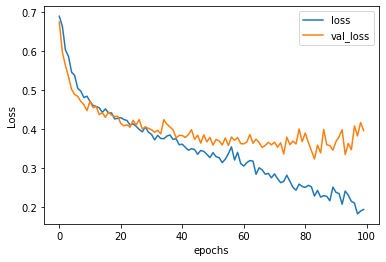

In [21]:
plt.plot(range(len(history.history["loss"])), history.history["loss"], label="loss")
plt.plot(range(len(history.history["loss"])), history.history["val_loss"], label="val_loss")
plt.xlabel("epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

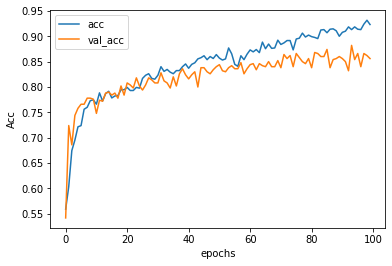

In [22]:
plt.plot(range(len(history.history["loss"])), history.history["acc"], label="acc")
plt.plot(range(len(history.history["loss"])), history.history["val_acc"], label="val_acc")
plt.xlabel("epochs")
plt.ylabel("Acc")
plt.legend()
plt.show()

# Metrics

In [ ]:
from sklearn.metrics import roc_curve, auc, roc_auc_score

In [41]:
y_val = []
X_val = []

val_gen.batch_size = 1

for i in range(val_gen.n):
    X, y = val_gen[i]
    
    y_val.append(y[0])
    X_val.append(X[0])

y_val = np.stack(y_val)
X_val = np.stack(X_val)

In [43]:
# generate a no skill prediction (majority class)
ns_probs = [0 for _ in range(val_gen.n)]

# predict probabilities

lr_probs = model.predict(X_val, verbose=1)

584/584 [==============================] - 0s 50us/step


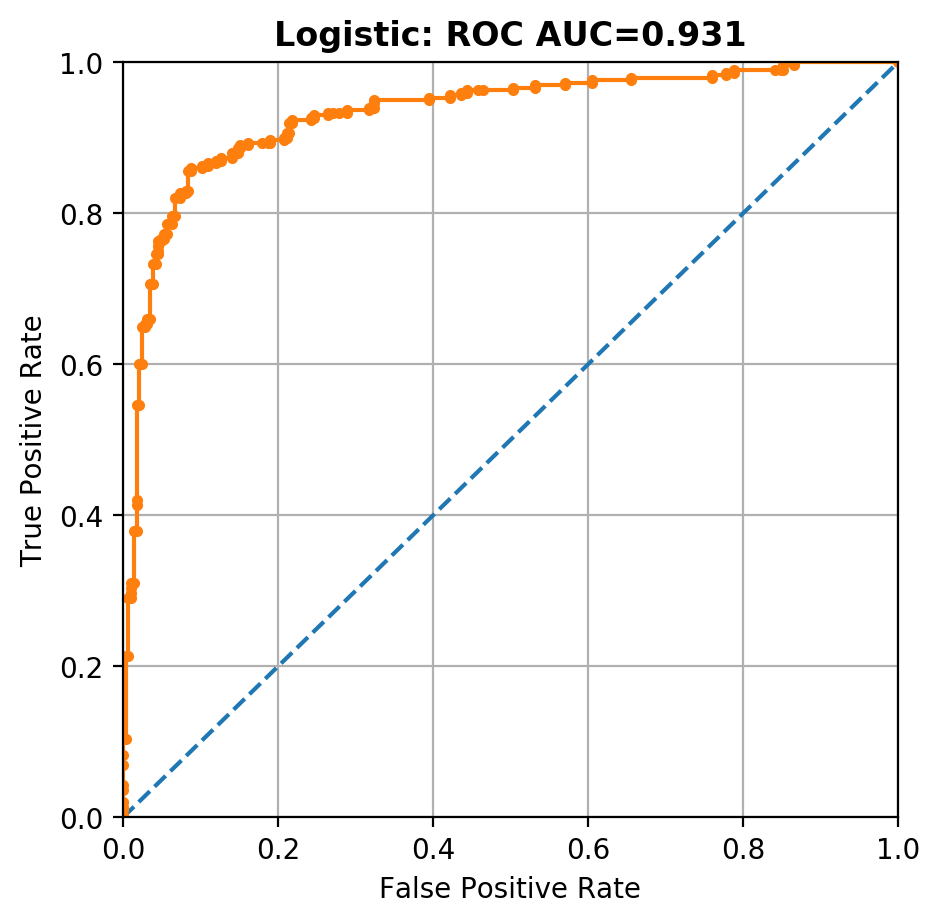

In [44]:
# calculate scores
ns_auc = roc_auc_score(y_val, ns_probs)
lr_auc = roc_auc_score(y_val, lr_probs)

# calculate roc curves
ns_fpr, ns_tpr, _ = roc_curve(y_val, ns_probs)
lr_fpr, lr_tpr, _ = roc_curve(y_val, lr_probs)

# plot the roc curve for the model
plt.figure(figsize=(5,5), dpi= 200)
plt.plot(ns_fpr, ns_tpr, linestyle='--', label='No Skill')
plt.plot(lr_fpr, lr_tpr, marker='.', label='Logistic')

# axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

# show the plot
plt.title('Logistic: ROC AUC=%.3f' % (lr_auc), fontweight='bold')
plt.xlim([0,1])
plt.ylim([0,1])
plt.grid()
plt.show()